In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [2]:
# =========================
# 1. Загрузка данных
# =========================

os.chdir('/home/konnilol/Documents/uni/mmo/pr6')
data = pd.read_csv('un.csv')

print("Dataset shape:", data.shape)
print("\nDataset info:")
print(data.describe())
print("\nColumns:", data.columns.tolist())

numeric_cols = data.select_dtypes(include=[np.number]).columns
X = data[numeric_cols].dropna()
print(f"\nNumeric features: {X.shape[1]} ({list(X.columns)})")

# Если есть столбец "color" как истинные метки, отделим его
true_labels = None
if 'color' in X.columns:
    true_labels = X['color'].values
    X = X.drop(columns=['color'])
    print("\nDetected true labels column: 'color'")
    print("X shape after dropping 'color':", X.shape)


Dataset shape: (5957, 3)

Dataset info:
                 x            y        color
count  5957.000000  5957.000000  5957.000000
mean    166.778887   186.591298     0.443344
std      59.393396    62.077982     0.496821
min      56.271798    63.078706     0.000000
25%     124.520242   141.765027     0.000000
50%     167.342327   188.892522     0.000000
75%     216.185387   241.040733     1.000000
max     267.919497   289.928548     1.000000

Columns: ['x', 'y', 'color']

Numeric features: 3 (['x', 'y', 'color'])

Detected true labels column: 'color'
X shape after dropping 'color': (5957, 2)


In [3]:
# =========================
# 2. Нормализации
# =========================

normalizers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "None": None,
}


In [4]:
# =========================
# 3. Обёртки методов кластеризации (k до 10)
# =========================

def run_kmeans_auto_k(X_norm, k_min=2, k_max=10):
    best = None
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_norm)
        if len(np.unique(labels)) < 2:
            continue
        sil = silhouette_score(X_norm, labels)
        ch = calinski_harabasz_score(X_norm, labels)
        db = davies_bouldin_score(X_norm, labels)
        if (best is None) or (sil > best["Silhouette"]):
            best = {
                "model": "KMeans",
                "k": k,
                "labels": labels,
                "Silhouette": sil,
                "CH": ch,
                "DB": db,
                "extra": {"centers": km.cluster_centers_},
            }
    return best

def run_agg_auto_k(X_norm, k_min=2, k_max=10, linkage="ward"):
    best = None
    for k in range(k_min, k_max + 1):
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_norm)
        if len(np.unique(labels)) < 2:
            continue
        sil = silhouette_score(X_norm, labels)
        ch = calinski_harabasz_score(X_norm, labels)
        db = davies_bouldin_score(X_norm, labels)
        if (best is None) or (sil > best["Silhouette"]):
            best = {
                "model": f"Agglomerative({linkage})",
                "k": k,
                "labels": labels,
                "Silhouette": sil,
                "CH": ch,
                "DB": db,
                "extra": {},
            }
    return best


In [5]:
# =========================
# 4. Запуск всех комбинаций
# =========================

results = []

for norm_name, scaler in normalizers.items():
    print("\n" + "=" * 80)
    print(f"Normalization: {norm_name}")
    print("=" * 80)

    if scaler is None:
        X_norm = X.values
    else:
        X_norm = scaler.fit_transform(X)

    # 4.1 KMeans (k от 2 до 10)
    km_best = run_kmeans_auto_k(X_norm, 2, 10)
    if km_best is not None:
        km_best["Normalization"] = norm_name
        results.append(km_best)
        print(
            f"KMeans best for {norm_name}: k={km_best['k']}, "
            f"Sil={km_best['Silhouette']:.4f}, CH={km_best['CH']:.1f}, DB={km_best['DB']:.3f}"
        )

    # 4.2 Agglomerative (ward) (k от 2 до 10)
    agg_best = run_agg_auto_k(X_norm, 2, 10, linkage="ward")
    if agg_best is not None:
        agg_best["Normalization"] = norm_name
        results.append(agg_best)
        print(
            f"Agglomerative(ward) best for {norm_name}: k={agg_best['k']}, "
            f"Sil={agg_best['Silhouette']:.4f}, CH={agg_best['CH']:.1f}, DB={agg_best['DB']:.3f}"
        )



Normalization: StandardScaler
KMeans best for StandardScaler: k=10, Sil=0.5002, CH=11129.5, DB=0.620
Agglomerative(ward) best for StandardScaler: k=8, Sil=0.4685, CH=7981.3, DB=0.634

Normalization: MinMaxScaler
KMeans best for MinMaxScaler: k=10, Sil=0.5013, CH=11225.9, DB=0.616
Agglomerative(ward) best for MinMaxScaler: k=7, Sil=0.4601, CH=7678.1, DB=0.712

Normalization: RobustScaler
KMeans best for RobustScaler: k=10, Sil=0.5016, CH=11266.5, DB=0.615
Agglomerative(ward) best for RobustScaler: k=8, Sil=0.4701, CH=8538.5, DB=0.661

Normalization: None
KMeans best for None: k=10, Sil=0.4984, CH=10971.6, DB=0.629
Agglomerative(ward) best for None: k=10, Sil=0.4636, CH=9543.3, DB=0.657


In [6]:
# =========================
# 5. Сводная таблица и выбор лучшего
# =========================

rows = []
for r in results:
    rows.append({
        "Model": r["model"],
        "Normalization": r["Normalization"],
        "k": r["k"],
        "Silhouette": r["Silhouette"],
        "CH": r["CH"],
        "DB": r["DB"],
    })

results_df = pd.DataFrame(rows).sort_values("Silhouette", ascending=False)

print("\n" + "=" * 80)
print("SUMMARY (sorted by Silhouette)")
print("=" * 80)
print(results_df.to_string(index=False))

best_overall = results_df.iloc[0]
print("\nBEST OVERALL:")
print(best_overall)

# Найдём объект с метками для лучшего результата
for r in results:
    if (
        r["model"] == best_overall["Model"]
        and r["Normalization"] == best_overall["Normalization"]
        and r["k"] == best_overall["k"]
    ):
        best_result = r
        break

# ВОССТАНОВЛЕНИЕ ЛУЧШИХ МАСШТАБИРОВАННЫХ ДАННЫХ И МЕТОК

best_norm_name = best_result["Normalization"]

if best_norm_name == "None":
    X_best_norm = X.values
else:
    scaler = normalizers[best_norm_name]
    X_best_norm = scaler.fit_transform(X)

labels_best = best_result["labels"]



SUMMARY (sorted by Silhouette)
              Model  Normalization  k  Silhouette           CH       DB
             KMeans   RobustScaler 10    0.501588 11266.538586 0.614554
             KMeans   MinMaxScaler 10    0.501335 11225.921011 0.615622
             KMeans StandardScaler 10    0.500229 11129.531042 0.620388
             KMeans           None 10    0.498357 10971.598845 0.628737
Agglomerative(ward)   RobustScaler  8    0.470082  8538.502839 0.661199
Agglomerative(ward) StandardScaler  8    0.468476  7981.290859 0.633825
Agglomerative(ward)           None 10    0.463580  9543.345878 0.656580
Agglomerative(ward)   MinMaxScaler  7    0.460067  7678.083876 0.711516

BEST OVERALL:
Model                  KMeans
Normalization    RobustScaler
k                          10
Silhouette           0.501588
CH               11266.538586
DB                   0.614554
Name: 4, dtype: object


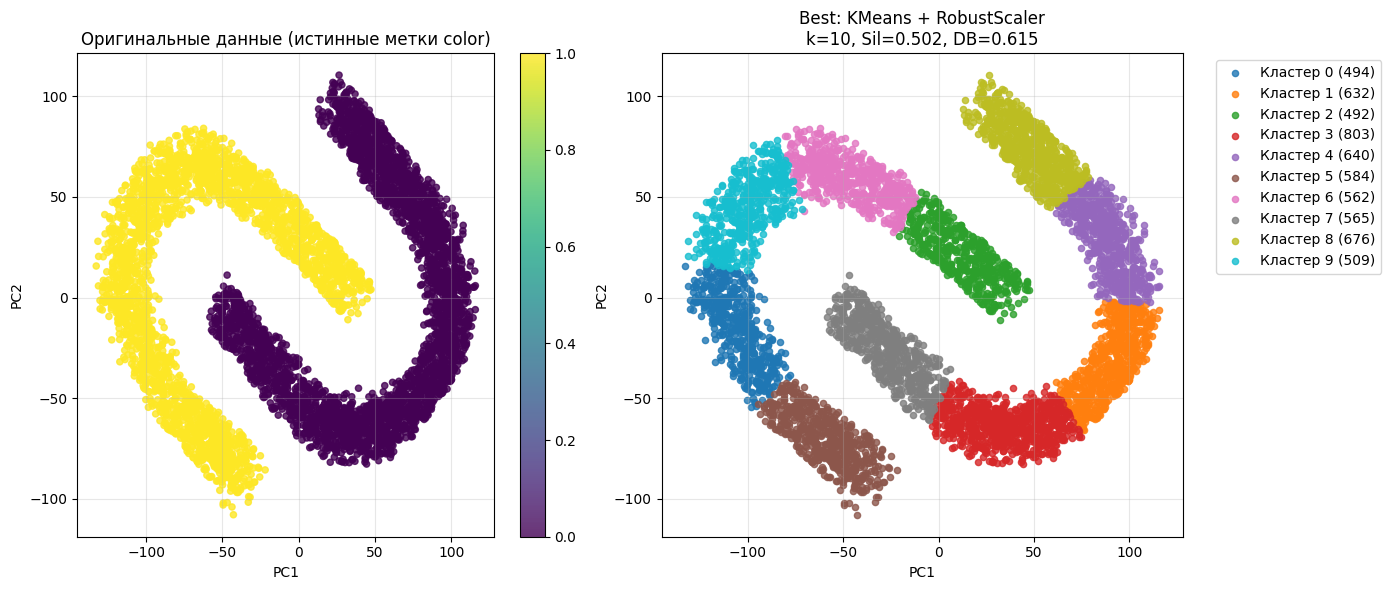

In [7]:
# =========================
# 6. Визуализация лучшей кластеризации
# =========================

# PCA до 2D для визуализации
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 6.1 Оригинальные данные (если есть истинные метки)
if true_labels is not None:
    sc1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=true_labels, cmap="viridis", s=20, alpha=0.8)
    axes[0].set_title("Оригинальные данные (истинные метки color)")
    plt.colorbar(sc1, ax=axes[0])
else:
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                    c="lightgray", s=20, alpha=0.8)
    axes[0].set_title("Оригинальные данные (без меток)")

axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(alpha=0.3)

# 6.2 Лучшая кластеризация
uniq = np.unique(labels_best)
cmap = plt.cm.get_cmap("tab10", len(uniq))
for i, lab in enumerate(uniq):
    mask = labels_best == lab
    color = "red" if lab == -1 else cmap(i)
    label_text = f"Кластер {lab} ({mask.sum()})" if lab != -1 else f"Шум/выбросы ({mask.sum()})"
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[color], s=20, alpha=0.8, label=label_text)

axes[1].set_title(
    f"Best: {best_result['model']} + {best_norm_name}\n"
    f"k={best_result['k']}, Sil={best_result['Silhouette']:.3f}, DB={best_result['DB']:.3f}"
)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [8]:
# =========================
# 7. Краткая текстовая интерпретация в консоли
# =========================

print("\nINTERPRETATION:")
print(f"- Best model: {best_result['model']}")
print(f"- Normalization: {best_norm_name}")
print(f"- Number of clusters (k or effective): {best_result['k']}")
print(f"- Silhouette: {best_result['Silhouette']:.4f}")
print(f"- Calinski-Harabasz: {best_result['CH']:.1f}")
print(f"- Davies-Bouldin: {best_result['DB']:.3f}")




INTERPRETATION:
- Best model: KMeans
- Normalization: RobustScaler
- Number of clusters (k or effective): 10
- Silhouette: 0.5016
- Calinski-Harabasz: 11266.5
- Davies-Bouldin: 0.615


### наилучшей комбинацией было kmeans + robustScaler с 10 кластерами (что я и так уже ограничил. До этого оно делало по 20+ кластеров в автоопределении). Мне кажется что кл-во кластеров такое высокое из-за распределения точек. В сходных данных, где 2 кластера, много где точки из кластера 2 ближе к точкам из первого, чем остальные из первого (ну и наоборот конечно...) и алгоритм решает что лучше разбить на большее кол-во кластеров, за-то не смешиваются 1 и 2 кластер.